# [java多线程编程详细入门教程_未完全理解](https://blog.csdn.net/liuyuanq123/article/details/80264583)

# 概念
线程是jvm调度的最小单元，也叫做轻量级进程，进程是由线程组成，线程拥有私有的程序技术器以及栈，并且能够访问堆中的共享资源。这里提出一个问题，为什么要用多线程？有一下几点，首先，随着cpu核心数的增加，计算机硬件的并行计算能力得到提升，而同一个时刻一个线程只能运行在一个cpu上，那么计算机的资源被浪费了，所以需要使用多线程。其次，也是为了提高系统的响应速度，如果系统只有一个线程可以执行，那么当不同用户有不同的请求时，由于上一个请求没处理完，那么其他的用户必定需要在一个队列中等待，大大降低响应速度，所以需要多线程。这里继续介绍多线程的几种状态：
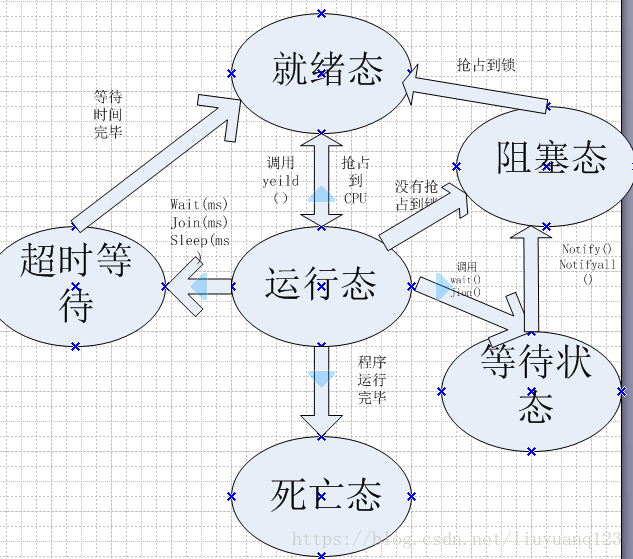

这里可以看到多线程有六种状态，分别是就绪态，运行态，死亡态，阻塞态，等待态，和超时等待态，各种状态之间的切换如上图所示。这里的状态切换是通过synchronized锁下的方法实现，对应的Lock锁下的方法同样可以实现这些切换。

# 线程的创建
线程的创建有两种方式，第一种是**继承Thread类**，第二种是**实现Runnable接口**。

第一种代码：

In [ ]:
class MyThread extends Thread{
    int j=20;
    public void run(){
        for (int i = 0; i < 20; i++) {
            try {
                Thread.sleep(100);  //休眠1min
            } catch (InterruptedException e) {
                // TODO Auto-generated catch block
                e.printStackTrace();
            }
            System.out.println(this.getName()+",i="+j--);//getName(): 该方法继承自Thread类
        }
    }
}

In [ ]:
MyThread mythread = new MyThread();
mythread.run();

第二种方法：

In [ ]:
class MyRunnable implements Runnable{
    int j=20;
    @Override//重写run方法
    public void run() {
        for (int i = 0; i < 20; i++) {
            System.out.println(Thread.currentThread().getName()+",j="+this.j--);
        }
    }
}

In [ ]:
MyRunnable myRunnable = new MyRunnable();
Thread t1 = new Thread(myRunnable);
Thread t2 = new Thread(myRunnable);
t1.start();
t2.start();

这就是两种创建线程的方法，在这两种方法中第二种方法时一般情况下的用法，因为继承只能继承一个类，但是可以实现多个接口，这样拓展性更好。

# 线程安全测试
线程安全是多线程编程中经常需要考虑的一个问题，*线程安全是指多线程环境下多个线程可能会同时对同一段代码或者共享变量进行执行*，**如果每次运行的结果和单线程下的结果是一致的，那么就是线程安全的，如果每次运行的结果不一致，那么就是线程不安全的**。这里对线程安全做一个测试：

In [ ]:
class MyRunnable implements Runnable{
    static int j=1000;
    @Override
    public void run() {
        for (int i = 0; i < 500; i++) {
            System.out.println(j--);
        }
    }
}

In [ ]:
MyRunnable myRunnable = new MyRunnable();
Thread t1 = new Thread(myRunnable);
Thread t2 = new Thread(myRunnable);
t1.start();
t2.start();

可以看到，这里同时两个线程同时对共享变量j进行访问，并且减1。

并且多次执行程序的结果还不一致，这就是线程不安全的情况，通过加锁可以保证线程安全。

# 锁
java中有两种锁，一种是**重量级锁synchronized**，*jdk1.6经过锁优化加入了偏向锁和轻量级锁*，另一种是JUC并发包下的Lock锁，synchronized锁也称对象锁，每个对象都有一个对象锁。这里通过加锁的方式实现线程安全：

代码：

In [ ]:
class MyRunnable implements Runnable{
    static int j=1000;
    @Override
    public synchronized void run() {
        for (int i = 0; i < 500; i++) {
            System.out.println(j--);
        }
    }
}

In [ ]:
MyRunnable myRunnable = new MyRunnable();
Thread t1 = new Thread(myRunnable);
Thread t2 = new Thread(myRunnable);
t1.start();
t2.start();

main中创建两个线程，测试多次的结果都是一样的：

说明实现的线程安全，因为当加锁过后，每次只能有一个线程访问被加锁的代码，这样就不会出现线程安全了。

# sleep
sleep是让当前线程睡眠，睡眠一段时间后重新获取到cpu的使用权。

代码如下：

In [ ]:
try {
    Thread.sleep(100);
} catch (InterruptedException e) {
    // TODO Auto-generated catch block
    e.printStackTrace();
}

这里表示线程会睡眠100ms后再次到就绪状态中，**这里为什么sleep是Thread的类方法而不是线程的方法，因为，能调用sleep的线程肯定是运行着的，而其他线程也是未运行的，所以调用其他线程的sleep是没有意义的**。

# wait、notify
**wait表示当前线程释放掉锁进入等待状态，所以调用wait和notify的前提是已经获取到对象的锁**，如果没有获取到锁就使用wait那么会出异常信息。而**进入等待状态的线程需要通过notify或者通过中断来唤醒进入到阻塞状态来等待锁的获取**。这里对这种情况进行测试，使用notify唤醒一个等待状态的线程

In [ ]:
class MyThreadd extends Thread{
    public MyThreadd(String name) {
        // TODO Auto-generated constructor stub
        super(name);
    }
    public void run(){
        synchronized (this) {
            System.out.println(Thread.currentThread().getName()+" notify a thread");
            notify();
        }
        while(true);
    }
}

In [ ]:
//main
MyThreadd t1 = new MyThreadd("t1");
synchronized (t1) {
    System.out.println(Thread.currentThread().getName()+" start t1");
    t1.start();
    System.out.println(Thread.currentThread().getName()+" wait");
    t1.wait();
    System.out.println(Thread.currentThread().getName()+" waked up");
}

这里可以看到，在main函数中，主线程将创建一个线程t1然后进入t1的锁的同步块中启动线程t1，然后调用wait进入等待状态，这个时候线程t1也进入到同步块中，调用notify后释放掉锁，可以看到主线程后续的东西继续被输出。当有多个线程调用了wait之后如果采用notify只会随机的唤醒其中的一个线程进入阻塞态，而采用notifyall会将所有的线程给唤醒。在线程运行结束后会调用notifyall将所有等待状态的线程唤醒。

# join
join的作用是让父线程等待子线程运行结束后在运行，通过查看源码可以知道：
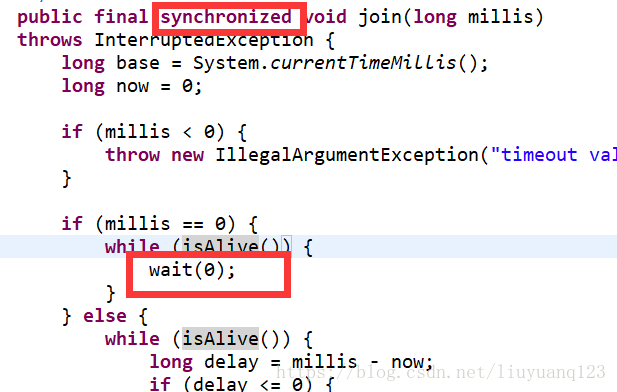

其实也是调用了先获取到子线程的锁然后调用wait方法来实现的，因为当子线程运行结束后会调用notifyall所以主线程会被唤醒并且再次获取到子线程的锁继续运行。

In [ ]:
class MyRuu extends Thread{
    public MyRuu(String name) {
        super(name);
    }
    public void run() {
        System.out.println(Thread.currentThread().getName());
        //while(true);
    }
}

In [ ]:
//main
MyRuu myRuu = new MyRuu("t1");
System.out.println(Thread.currentThread().getName()+" start t1");
myRuu.start();
System.out.println(Thread.currentThread().getName() +" join");
myRuu.join();
System.out.println(Thread.currentThread().getName() +" waked up");

可以看到，当主线程调用join后子线程开始运行，等子线程运行结束后主线程被唤醒。

# yeild
yeild的作用是线程让步，当前线调用yeild方法后线程从运行态进入到就绪态重新进入到CPU资源的竞争中。这里进行测试：

In [ ]:
class MyRun extends Thread{
    Object obj;
    public MyRun(String name,Object obj) {
        // TODO Auto-generated constructor stub
        super(name);
        this.obj = obj;
    }
    public void run(){
    //synchronized (obj) {
            for (int i = 0; i < 10; i++) {
                System.out.println(Thread.currentThread().getName()+ " i="+i);
                if(i%2 == 0)
                    Thread.yield();
            }
    //}
    }
}

In [ ]:
//main
Object obj = new Object();

MyRun t1 = new MyRun("t1",obj);
MyRun t2 = new MyRun("t2",obj);
t1.start();
t2.start();

可以看到他们两个基本上是交替运行，而不用yeild让步的话大概率一个线程执行完成了另一个线程才会执行。

In [ ]:
class MyRun_ extends Thread{
    Object obj;
    public MyRun_(String name,Object obj) {
        // TODO Auto-generated constructor stub
        super(name);
        this.obj = obj;
    }
    public void run(){
    synchronized (obj) {
            for (int i = 0; i < 10; i++) {
                System.out.println(Thread.currentThread().getName()+ " i="+i);
                if(i%2 == 0)
                    Thread.yield();
            }
    }
    }
}

In [ ]:
//main
Object obj = new Object();

//MyRun_ t1 = new MyRun_("t1",obj);
MyRun_ t2 = new MyRun_("t2",obj);
//t1.start();
t2.start();

# priority
priority代表线程的优先级，在JVM中优先级高的线程不一定会先运行，只是先运行的概率会比低优先级的线程大。

# 中断
对于一个正常运行的线程中，中断基本是没有作用的，只是作为一个标志位来查询。而线程的其他几种状态下如sleep、join、wait状态下是可以被中断，并且通过中断来跳出当前状态的。

In [ ]:
class RunInt extends Thread{
    public void run() {
        while(!this.isInterrupted()){
            synchronized (this) {
                for (int i = 0; i < 10; i++) {
                    System.out.println(Thread.currentThread().getName()+" i="+i);
                }
                try {
                    Thread.sleep(3000);
                } catch (InterruptedException e) {
                    System.out.println(Thread.currentThread().getName()+" interrupted!");
                    break;
                }
            }
        }
        System.out.println(Thread.currentThread().getName()+" dead");
    }
}

In [ ]:
//main
RunInt r1 = new RunInt();
r1.start();
Thread.yield();
synchronized (r1) {
    System.out.println(Thread.currentThread().getName()+" intertupt r1");
    r1.interrupt();
}

可以看到，当主线程启动子线程后，子线程会进入到循环中并且进入到睡眠状态，然后主线程通过调用中断让子线程唤醒并且推出循环后死亡。

# 死锁
死锁指的是，两个线程互相等待对方释放资源导致卡死。例子：

In [6]:
Thread t1 = new Thread(new Runnable() {
    @Override
    public void run() {
        synchronized("A") {
            try {
                Thread.sleep(1000);
            } catch (InterruptedException e) {
                e.printStackTrace();
            }
            synchronized("B") {
                System.out.println("haha");
            }
        }
    }
});

Thread t2 = new Thread(new Runnable() {
    @Override
    public void run() {
        synchronized("B") {
            synchronized("A") {
                System.out.println("xixi");
            }
        }
    }
});

In [7]:
t1.start();
t2.start();

可以看到t1线程获得A的锁然后睡眠，然后t2线程获得B的锁然后再等待A释放锁，而线程t1睡眠完成后在等待t2释放B的锁，导致程序卡死。

# 生产者与消费者
生产者和消费者是多线程中一个很常见的应用场景，这里首先用一个共享变量实现生产者和消费者，接着再使用阻塞队列实现。首先实现第一种：

仓库代码：

In [8]:
class Depot{
    private int capacity;
    private int size=0;
    public Depot(int c) {
        // TODO Auto-generated constructor stub
        this.capacity = c;
    }
    public synchronized void product(int count) throws InterruptedException{
        while(count>0){
            if(size >= capacity)
                wait();
            //真实生产数量
            int realcount = (capacity-size)>=count?count:(capacity-size);
            System.out.print(Thread.currentThread().getName()+"--本次想要生产："+count+",本次实际生产:"+realcount);
            //下次生产数量
            count = count - realcount;
            //仓库剩余
            size += realcount;
            System.out.println(",下次想要生产："+count+",仓库真实容量："+size);
            notifyAll();
        }
    }
    public synchronized void comsume(int count) throws InterruptedException {
        while(count>0){
            if(size <= 0)
                wait();
            //真实消费数量
            int realcount = (size>=count)?count:size;
            System.out.print(Thread.currentThread().getName()+"--本次想要消费:"+count+",本次真实消费："+realcount);
            //下次消费数量
            count = count - realcount;
            //仓库剩余
            size -= realcount;
            System.out.println("下次想要消费："+count+"，仓库剩余："+size);
            notify();
        }
    }
}

生产者代码：

In [9]:
class Producer {
    Depot depot;
    public Producer(Depot depot) {
        // TODO Auto-generated constructor stub
        this.depot = depot;
    }
    public void produce(final int count) {
        new Thread(){
            public void run() {
                try {
                    depot.product(count);
                } catch (InterruptedException e) {
                    // TODO Auto-generated catch block
                    e.printStackTrace();
                }
            }
        }.start();
    }
}

消费者代码：

In [10]:
class Consumer{
    Depot depot;
    public Consumer(Depot depot) {
        // TODO Auto-generated constructor stub
        this.depot = depot;
    }
    public void consume(final int count) {
        new Thread(new Runnable() {

            @Override
            public void run() {
                // TODO Auto-generated method stub
                try {
                    depot.comsume(count);
                } catch (InterruptedException e) {
                    // TODO Auto-generated catch block
                    e.printStackTrace();
                }
            }
        }).start();
    }
}

main中代码

In [11]:
Depot depot = new Depot(100);
Producer producer = new Producer(depot);
Consumer consumer = new Consumer(depot);
producer.produce(60);
producer.produce(50);
producer.produce(30);
consumer.consume(50);
consumer.consume(110);
producer.produce(40);

Thread-6--本次想要生产：60,本次实际生产:60,下次想要生产：0,仓库真实容量：60
Thread-7--本次想要生产：50,本次实际生产:40,下次想要生产：10,仓库真实容量：100
Thread-9--本次想要消费:50,本次真实消费：50下次想要消费：0，仓库剩余：50
Thread-7--本次想要生产：10,本次实际生产:10,下次想要生产：0,仓库真实容量：60
Thread-8--本次想要生产：30,本次实际生产:30,下次想要生产：0,仓库真实容量：90
Thread-10--本次想要消费:110,本次真实消费：90下次想要消费：20，仓库剩余：0


可以看到实现了生产者消费者模型。

第二种利用阻塞队列实现。直接利用阻塞队列当做仓库，生产者：

In [16]:
class Pro1{
    private BlockingQueue<Integer> blockingQueue1;
    public Pro1(BlockingQueue<Integer> blockingQueue) {
        // TODO Auto-generated constructor stub
        this.blockingQueue1 = blockingQueue;
    }
    public void produce(final int count) {
        new Thread(new Runnable() {

            @Override
            public void run() {
                // TODO Auto-generated method stub
                for (int i = 0; i < count; i++) {
                    try {
                        Thread.sleep(100);
                        blockingQueue1.put(100);
                        System.out.println("生产者，仓库剩余容量"+blockingQueue1.size());
                    } catch (InterruptedException e) {
                        // TODO Auto-generated catch block
                        e.printStackTrace();
                    }
                }
            }
        }).start();

    }
}

消费者：

In [17]:
class Con1{
    private BlockingQueue<Integer> blockingQueue;
    public Con1(BlockingQueue<Integer> blockingQueue) {
        // TODO Auto-generated constructor stub
        this.blockingQueue = blockingQueue;
    }
    public void consume(final int count) {
        new Thread(new Runnable() {

            @Override
            public void run() {
                // TODO Auto-generated method stub
                for (int i = 0; i < count; i++) {
                    try {
                        Thread.sleep(100);
                        blockingQueue.take();
                        System.out.println("消费者，本次仓库剩余："+blockingQueue.size());
                    } catch (InterruptedException e) {
                        // TODO Auto-generated catch block
                        e.printStackTrace();
                    }
                }
            }
        }).start();
    }
}

main函数：

In [18]:
BlockingQueue<Integer> blockingQueue = new ArrayBlockingQueue<Integer>(5);
Pro1 pro1 = new Pro1(blockingQueue);
Con1 con1 = new Con1(blockingQueue);
pro1.produce(10);
con1.consume(7);

这里阻塞队列的作用是，当容量不足的消费者进入等待队列，而当容量有剩余的时候消费者被唤醒，当容量已满的时候生产者进入等待队列，当容量被消费后生产者被唤醒。